# Reaction coordinate analysis of the Müller Brown potential

In this notebook, we will compute the reaction coordinate of the Müller Brown potential system, a two-dimensional Brownian dynamics often used as a benchmark for system analysis and model reduction methods. As this system is available in analytical form, we will be able to generate our own dynamical data. 

This notebook will teach you how to

- set up the data structure containing the system and its parameters
- generate the dynamical data used as input for the machine learning methods
- apply two variants of the burst-based transition manifold method to the data, namely
    - the Whitney embedding variant
    - the kernel embedding variant

---

We start by importing the necessary external python packages and setting up the environment.

In [1]:
# Generic imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(0)

# Numerics imports
import numpy as np

from scipy.cluster.vq import kmeans

# Visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Next, we import the necessary modules from the TMRC package.

In [2]:
# Tell python where to find the TMRC package
sys.path.insert(0,'../..')

# Import TMRC modules
import tmrc.system as dynsys
import tmrc.kernels as krnls
import tmrc.transition_manifold as tm
import tmrc.embedding_functions as emb

### System setup

We now need to set up the dynamical system that we want to analyze. The Müller Brown system is a Brownian dynamics, i.e., its equations of motion are given by the stochastic differential equation

$$dX_t = -\nabla V(X_t) + \sqrt{2\beta^{-1}}dW_t,$$

where $V$ is the potential, $W_t$ is a standard Wiener process, i.e., the source of the noise in the system, and $\beta$ is the inverse temperature which determines the strength of the noise.

The potential is loaded from the module `mbpotential`, provided with this notebook. Together with the remaining parameters, it is used to instantiate an object of the `GradientSystem` class, which will later be passed to the simulation and manifold learning methods.

In [3]:
# Load the potential
import mbpotential
mypotential = mbpotential.Potential()

# Set up system parameters
domain = np.array([[-1.5, -0.5], [1, 2]]) # boundaries of the system's domain
beta = 0.05 # inverse temperature

# Create a GradientSystem object
mbsystem = dynsys.GradientSystem(mypotential, domain, beta)

The potential can be visualized by evaluating it on a grid of points covering the domain and plotting the values as a heat map:

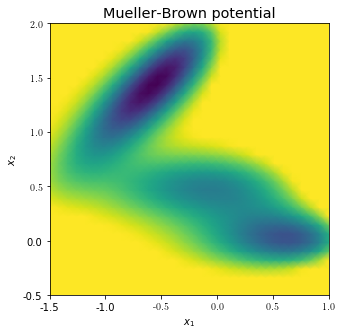

In [4]:
# generate evaluation points on grid
nPotpoints = 32
xpot = mbsystem.generateTestpoints(nPotpoints, 'grid')

# evaluate potential in the points
V = mbsystem.pot(xpot)

# plot the values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh( xpot[:,0].reshape(nPotpoints, -1), xpot[:,1].reshape(nPotpoints, -1), V.reshape(nPotpoints,-1), cmap='viridis', vmax=10, shading='gouraud')

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 12}
plt.rc('font', **font)
fig.set_size_inches(5,5)
ax.set_title(r'Mueller-Brown potential')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

The three local minima that define the system's characterisic long-term behaviour can be seen. Any reasonably good reaction coordinate should distinguish the minima and vary smoothly along the transition pathways connecting them.

### Data generation

Next we generate dynamical data about the system via trajectory integration. Specifically, we first cover the state space in a regular grid of test points, that will become the points in which the reaction coordinate values will be computed. Then, multiple short trajectories are generated from each test point by solving the above SDE via the Euler-Maruyama stochastic integration scheme up to time $t$. $t$ must be chosen to fall in between the slow and the fast time scales. This yields samplings of the transition density functions associated with each test point. 

In [5]:
# generate a 32x32 grid of test points
ntest = 32
xtest = mbsystem.generateTestpoints(ntest, 'grid')

# parameters of the integration
t = 0.02 # end time
dt = 0.00002 # time step
M = 100 # number of trajectories per starting point, i.e., size of the point clouds

# simulate M trajectories of length t for each test point via the Euler-Maruyama integrator.
X = mbsystem.generatePointclouds(t, dt, xtest, M)

Generating poinclouds...


100%|██████████| 1024/1024 [04:49<00:00,  3.53it/s]


The output `X` is a three-fold nested NumPy array, where each entry of `X` is an array containing the `M` points of the `ntest` point clouds. These points are again in general multi-dimensional (two-dimensional in this case), and thus are again saved as arrays.

The plot below shows a visualization of three of the 1024 point clouds:

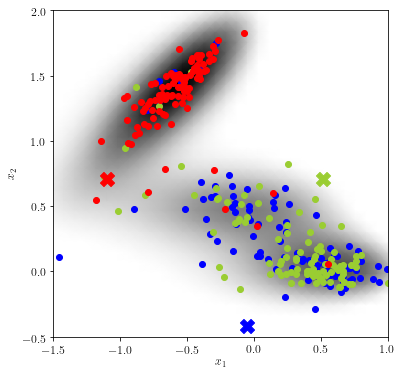

In [6]:
# structure of X
np.shape(X)

# plot potential and two point clouds
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh( xpot[:,0].reshape(nPotpoints, -1), xpot[:,1].reshape(nPotpoints, -1), V.reshape(nPotpoints,-1), cmap='Greys_r', vmax=12, shading='gouraud')

plt.scatter(X[50,:,0],X[50,:,1], c='blue') # plot point cloud starting from xtest[50,:]
plt.scatter(X[505,:,0],X[505,:,1], c='yellowgreen') # plot point cloud starting from xtest[500,:]
plt.scatter(X[485,:,0],X[485,:,1], c='red') # plot point cloud starting from xtest[100,:]

plt.scatter(xtest[50,0], xtest[50,1], s=200, marker='X', c='blue') # plot xtest[50,:]
plt.scatter(xtest[505,0], xtest[505,1], s=200, marker='X', c='yellowgreen') # plot xtest[500,:]
plt.scatter(xtest[485,0], xtest[485,1], s=200, marker='X', c='red') # plot xtest[100,:]

plt.xlim(-1.5, 1)
plt.ylim(-0.5, 2)
fig.set_size_inches(6,6)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

Informally speaking, the "more similar" two point clouds are, the closer the reaction coordinate value of their originating test points will be. We can expect the blue and green test point to have similar reaction coordinate values, whereas the value at the red test point will presumably differ.

The two variants of the transition manifold method, i.e., the Whitney embedding and the kernel embedding variant, now differ only in the metric used for the similarity measure of the point clouds.

## Method 1: Whitney embedding

We first demonstrate the method based on random Whitney embeddings. Its basic idea is to embedd each point cloud into a Euclidean space using randomly-drawn linear observables, and use as the distance between the point clouds the Euclidean distance between the embedding points. 

More precisely, say $\{y^{(1)},\ldots,y^{(M)}\}$ is the point cloud sampling the transition density function $p^t(x,\cdot)$. Let $f:\mathbb{R}^2\rightarrow \mathbb{R}^r$ be some smooth $r$-dimensional observable. Then the *Whitney embedding* of the point cloud is computed as

$$
\mathcal{F}(x) = \frac{1}{M} \sum_{i=1}^M f(y^{i}).
$$

A distance measure between two point clouds starting from test points $x^{(1)}$ and $x^{(2)}$, respectively, can then be defined by

$$
\| \mathcal{F}(x^{(1)}) - \mathcal{F}(x^{(2)}) \|
$$

where $\|\cdot\|$ is the Euclidean norm in $\mathbb{R}^{r}$. 
A rigorous discussion of this embedding can be found in https://doi.org/10.1007/s00332-017-9415-0.

### Random linear embedding

We first need to select the embedding function $f$. According to the Whitney embedding theorem, the dimension $r$ of the image of $f$ needs to be larger than twice the expected reaction coordinate dimension. As we here expect a RC dimesnsion of one, we here select $r=3$.

For the observable itself, we will use a random linear function, i.e.,

$$
f(x) = Ax,
$$

where $A$ is a $r\times 2$ matrix with random entries. The class `RandomLinearEmbeddingFunction` of the module `embedding_functions` allows to easily construct such an observable.

In [7]:
# construct the Whitney embedding

r = 3 # embedding dimension

# Construct the embedding function object.
# We orthonormalize the columns of A after random selection for increased stability
linembfun = emb.RandomLinearEmbeddingFunction(inputdimension=2, outputdimension=r, seed=1, orthonormalize = True)

The actual transition manifold is now set up in an `EmbeddingBurstTransitionManifold` object.

In [8]:
embTM=tm.EmbeddingBurstTransitionManifold(linembfun)
embTM.embedd(X)

np.shape(embTM.embpointclouds)

Evaluating observables...


100%|██████████| 1024/1024 [00:00<00:00, 39239.93it/s]


(1024, 3)

We can visualize the embedded data. Each point in the plot below corresponds to one point cloud (i.e., `M` points in $\mathbb{R}^2$).

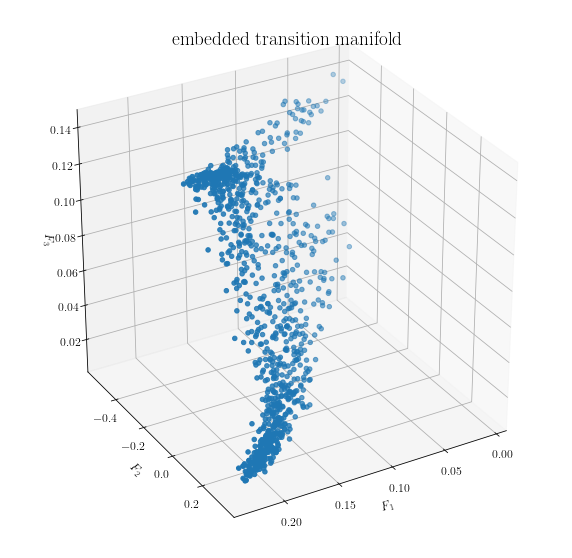

In [9]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embTM.embpointclouds[:,0], embTM.embpointclouds[:,1], embTM.embpointclouds[:,2])

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
ax.set_xlabel(r'$F_1$')
ax.set_ylabel(r'$F_2$')
ax.set_zlabel(r'$F_3$')
ax.set_title(r'embedded transition manifold')

fig.set_size_inches(10,10)
ax.view_init(30, 60)
plt.show()


### Manifold learning

As a final step, we can apply an appropriate off-the-shelf manifold learning algorithm to the embedded points and learn a low-dimensional parametrization of the manifold structure. The TMRC package implements the diffusion maps algorithm with the Gaussian kernel for this purpose, which is invoked by the `fit()` method of the `TransitionManifold` class. 

The diffusion maps algorithm actually computes a hierarchy of reaction coordinates, with higher dimensions corresponding to less significant features of the embedded transition manifold. The reaction coordinate of desired dimension `r` can be extracted by the `predict` method. Looking at the above picture of the embedded transition manifold, we expect a one-dimensional reaction coordinate to explain the structure well.

In [10]:
# learn the structure of the embedded TM by diffusion maps
embTM.fit(X)

# extract the r leading diffusion map eigenvectors as the final reaction coordinate
r = 1
xi = embTM.predict(r)

Evaluating observables...


100%|██████████| 1024/1024 [00:00<00:00, 36631.16it/s]


As shown below, the output vector `xi` of `predict` is indeed a parametrization of the longest direction of the embedded transition manifold. 

The vector `xi` can be interpreted as the reaction coordinate evaluated at the test points `xtest`. It can be extended to the complete domain by interpolation, and then visualized accordingly. We see a rather sharp divide between the upper minima and the unification of the bottom two minima. Overall, the computed reaction coordinate resembles the so-called *committor function* associated with the top and bottom minima, which has been described as the optimal reaction coordinate for this system (for a comparison, see https://arxiv.org/abs/1904.08622)

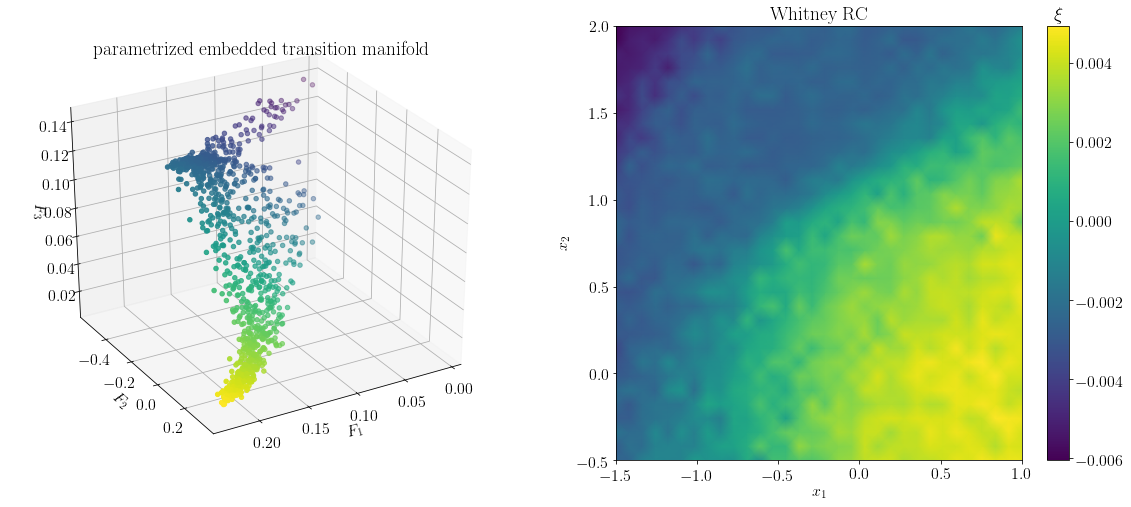

In [11]:
fig = plt.figure()

# visualize parametrized embedded transition manifold 
ax = fig.add_subplot(121, projection='3d')
ax.scatter(embTM.embpointclouds[:,0], embTM.embpointclouds[:,1], embTM.embpointclouds[:,2], c=xi[:,0])

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
ax.set_xlabel(r'$F_1$')
ax.set_ylabel(r'$F_2$')
ax.set_zlabel(r'$F_3$')
ax.set_title(r'parametrized embedded transition manifold')
ax.view_init(30, 60)

# visualize reaction coordinate in test points
ax = fig.add_subplot(122)
pcol = ax.pcolormesh( xtest[:,0].reshape(ntest, -1),
             xtest[:,1].reshape(ntest, -1),
             np.real(xi[:,0].reshape(ntest,-1)),
             shading='gouraud',
             )

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
fig.set_size_inches(5,5)
ax.set_title(r'Whitney RC')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

clb = fig.colorbar(pcol)
clb.ax.set_title(r'$\xi$')

fig.set_size_inches(20,8)
plt.show()


## Method 2: Kernel embedding

While in the above example the usage of random linear embedding function $\mathcal{F}(x) = Ax$ proofs effective, the procedure can be numerically unstable if the normal vectors of the rows of $A$ are almost perpendicular to the most significant direction fo the transition manifold. As the structure of the transition manifold is unknown a priori, this problem in general cannot be effectively avoided.

As a solution, we proposed the usage of a *kernel embedding*, and a corresponding *kernel distance* for measuring distances between transition densities (or rather, samplings of them). The procedure is described in detail in https://arxiv.org/abs/1904.08622.

Let again $\{y^{(1)},\ldots,y^{(M)}\}$ be the point cloud sampling the density $p^t(x,\cdot)$. Furthermore let $k:\mathbb{R}^2\times \mathbb{R}^2 \rightarrow \mathbb{R}$ be a positive definite function, which we will call a *kernel*.

As the embedding function, we then use

$$
\mathcal{G}(x) := \frac{1}{M} \sum_{i=1}^M k (y^{(i)},\cdot).
$$

Note that $\mathcal{G}(x)$ is no longer a point in some Euclidean space, but a member of a function space, the so-called *reproducing kernel Hilbert space* (RKHS) associated with $k$. Hence, the embedded point clouds $\mathcal{G}(x)$ can no longer be directly visualized, and in fact are never computed explicitly. However, their *distance* in the RKHS can be computed using only kernel evaluations at the sampling points:

$$
d\big(\mathcal{G}(x_1),\mathcal{G}(x_2)\big) := \big\langle \mathcal{G}(x_1),\mathcal{G}(x_1)\big\rangle + \big\langle \mathcal{G}(x_2),\mathcal{G}(x_2)\big\rangle -2 \big\langle \mathcal{G}(x_1),\mathcal{G}(x_2)\big\rangle 
$$

where 

$$
\big\langle \mathcal{G}(x_1),\mathcal{G}(x_2)\big\rangle := \frac{1}{M^2} \sum_{i,j = 1}^M k(y_1^{(i)} y_2^{(j)}).
$$

The manifold learning via diffusion maps will then be performed with respect to the distance measure $d$.

### Kernel embedding function

For this example, we use the popular *Gaussian kernel*, defined by

$$
k(x,y) = \operatorname{exp}\big(\|x-y\|^2\big/\sigma^2)
$$

where $\sigma$ is called the *bandwidth* of the kernel. In TMRC, the Gaussian kernel is implemented in the `kernels.GaussianKernel` class:

In [12]:
# construct a Gaussian kernel object
sigma = 1 # the Gaussian kernel bandwidth
kernel = krnls.GaussianKernel(sigma)

The transition manifold based on this kernel is set up in a `KernelBurstTransitionManifold` object.

In [13]:
kerTM = tm.KernelBurstTransitionManifold(kernel)

### Manifold learning

As the point cloud embeddings are never computed explicitly, `KernelBurstTransitionManifold` has no `embedd()` method. Instead, the `fit()` method is directly run on the point cloud data, which performs the diffusion maps algorithm in the RKHS. We again predict a one-dimensional reaction coordinate.

In [14]:
# learn the structure of the embedded TM by diffusion maps
kerTM.fit(X)

# extract the r leading diffusion map eigenvectors as the final reaction coordinate
r = 1
xi_ker = kerTM.predict(r)

Computing symmetric kernel evaluations...


100%|██████████| 1024/1024 [00:00<00:00, 6224.13it/s]

Computing asymmetric kernel evaluations...



100%|██████████| 1024/1024 [01:20<00:00, 12.69it/s]


Again, the output vector `xi_ker` contains the values of the reaction coordinate evaluated at the test points. Overall, the reaction coordinate resembles that of the Whitney embedding method. In particular, the characteristic sharp transition between the top minimum and the two bottom lower minima is present.

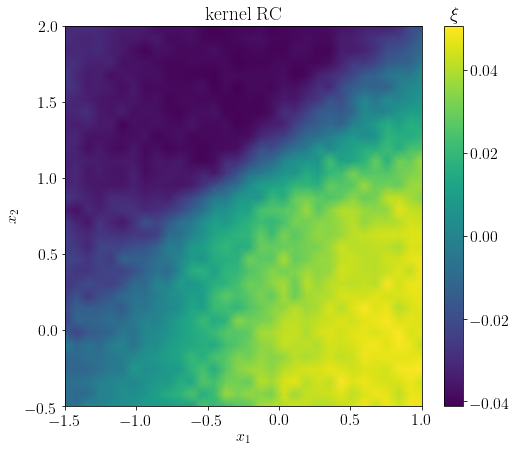

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

# visualize RC
pcol = ax.pcolormesh( xtest[:,0].reshape(ntest, -1),
             xtest[:,1].reshape(ntest, -1),
             np.real(kerTM.rc[1][:,1].reshape(ntest,-1)),
             shading='gouraud',
             )
clb = fig.colorbar(pcol)
clb.ax.set_title(r'$\xi$')

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
fig.set_size_inches(8,7)
ax.set_title(r'kernel RC')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()